In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import KMeansSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier


In [ ]:
# load data from google drive
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/IntroMLFinalProject/train.csv')
test = pd.read_csv('/content/drive/MyDrive/IntroMLFinalProject/test_imputed.csv')
val = pd.read_csv('/content/drive/MyDrive/IntroMLFinalProject/validation.csv')

Mounted at /content/drive


In [ ]:
train['RemovedTeeth'].unique()

array([nan, '1 to 5', 'More than 6', 'All'], dtype=object)

In [ ]:
#drop Unnamed from test
test = test.drop('Unnamed: 0', axis=1)
#val = val.drop('Unnamed: 0', axis=1)
test = test.drop('State', axis = 1)
val = val.drop('State', axis = 1)
train = train.drop('State', axis = 1)

In [ ]:
# for RemovedTeeth, replace nan with 0 for both sets
train['RemovedTeeth'] = train['RemovedTeeth'].fillna(0, inplace=True)
test['RemovedTeeth'] = test['RemovedTeeth'].fillna(0, inplace=True)
val['RemovedTeeth'] = val['RemovedTeeth'].fillna(0, inplace=True)

<ipython-input-4-a8f4f1d567d7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RemovedTeeth'] = train['RemovedTeeth'].fillna(0, inplace=True)
<ipython-input-4-a8f4f1d567d7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [ ]:
# clean the response data, yes = 1 no = 0
train = train.replace({'Yes': 1, 'No': 0})
test = test.replace({'Yes': 1, 'No': 0})
val = val.replace({'Yes': 1, 'No': 0})

<ipython-input-5-3afe61abc4e0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.replace({'Yes': 1, 'No': 0})
<ipython-input-5-3afe61abc4e0>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test = test.replace({'Yes': 1, 'No': 0})
<ipython-input-5-3afe61abc4e0>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_dow

In [ ]:
from re import X
Response = 'HadHeartAttack'
X_train = train.drop(Response, axis=1)
y_train = train[Response]

X_test = test.drop(Response, axis=1)
y_test = test[Response]

X_val = val.drop(Response, axis=1)
y_val = val[Response]

# Create a LabelEncoder object
lbencoder = LabelEncoder()
one_encoder = OneHotEncoder()



# List of columns with object dtype to label encode
object_cols_lb = ['GeneralHealth', 'LastCheckupTime',
               'RemovedTeeth', 'SmokerStatus',
               'ECigaretteUsage', 'AgeCategory']


object_cols_one = ['Sex', 'RaceEthnicityCategory',
                   'CovidPos', 'HadAngina', 'HadStroke', 'HadAsthma',
                   'HadDiabetes', 'HadSkinCancer', 'HadKidneyDisease',
                   'HadCOPD', 'HadDepressiveDisorder', 'HadArthritis',
                   'TetanusLast10Tdap', 'DifficultyWalking',
                   'DifficultyConcentrating', 'BlindOrVisionDifficulty',
                   'DeafOrHardOfHearing', 'ChestScan', 'DifficultyErrands',
                   'DifficultyDressingBathing', 'AlcoholDrinkers', 'HIVTesting',
                   'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'PhysicalActivities'
                   ]

for col in object_cols_lb:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    X_val[col] = X_val[col].astype(str)

# Encode the categorical features in both training and testing data
for col in object_cols_lb:
    X_train[col] = lbencoder.fit_transform(X_train[col])
    X_test[col] = lbencoder.transform(X_test[col]) # Use transform, not fit_transform for test data
    X_val[col] = lbencoder.transform(X_val[col])

# dummy
for col in object_cols_one:
    #X_train[col] = X_train[col].astype(str)
    #X_test[col] = X_test[col].astype(str)
    X_train = pd.get_dummies(X_train, columns=[col])
    X_test = pd.get_dummies(X_test, columns=[col])
    X_val = pd.get_dummies(X_val, columns=[col])

In [ ]:
def get_scores(model, X_train, X_test, y_train, y_test, print_result = False, title = 'XGBoost Confusion Matrix'):

  # print model information
  #print(model)

  # test the model using test data
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)


  # recall rate
  recall = recall_score(y_test, y_pred)


  # precision rate
  precision = precision_score(y_test, y_pred)


  # f1 score
  # f1_score = 2 * (precision * recall) / (precision + recall)

  f1 = f1_score(y_test, y_pred)



  if print_result:
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    # plot a confusion matrix
    # add title
    plt.title(title)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
  return accuracy, recall, precision, f1

Accuracy: 0.9372497568258421
Recall: 0.5324313569438918
Precision: 0.45556690500510727
F1 Score: 0.4910091743119266


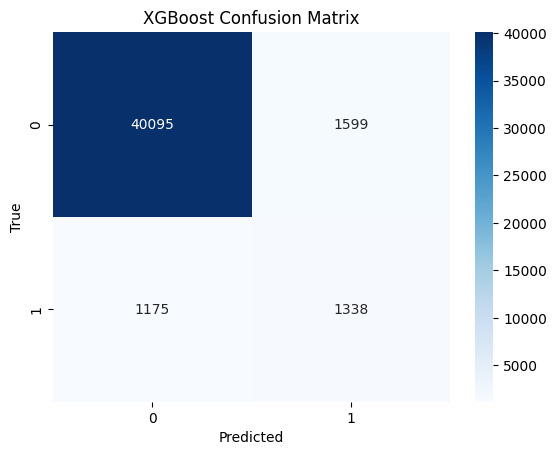

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     41694
           1       0.46      0.53      0.49      2513

    accuracy                           0.94     44207
   macro avg       0.71      0.75      0.73     44207
weighted avg       0.94      0.94      0.94     44207



In [ ]:
# Best model so far, evluated on val
xgb_best = XGBClassifier(scale_pos_weight=4, max_depth=4, min_child_weight=235, eta = 0.068)
xgb_best.fit(X_train, y_train)
acc, rec, pre, f1 = get_scores(xgb_best, X_train, X_val, y_train, y_val, print_result=True)


Accuracy: 0.9360056099712715
Recall: 0.5307906237584425
Precision: 0.4477211796246649
F1 Score: 0.48572986729685513


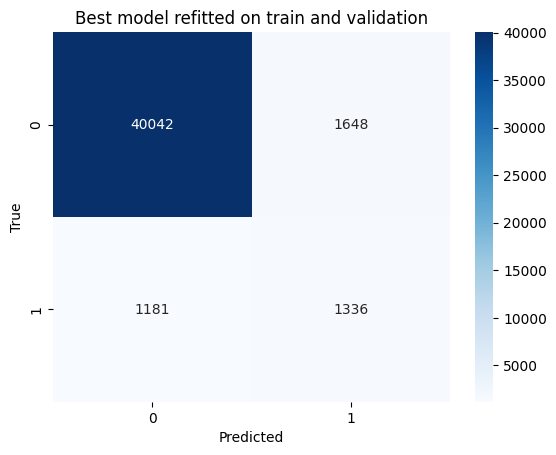

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     41690
           1       0.45      0.53      0.49      2517

    accuracy                           0.94     44207
   macro avg       0.71      0.75      0.73     44207
weighted avg       0.94      0.94      0.94     44207



In [ ]:
# best model so far, fit on both train and val
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
xgb_best = XGBClassifier(scale_pos_weight=4, max_depth=4, min_child_weight=235, eta = 0.068)
xgb_best.fit(X_trainval, y_trainval)
acc, rec, pre, f1 = get_scores(xgb_best, X_trainval, X_test, y_trainval, y_test, print_result=True, title= 'Best model refitted on train and validation')

In [107]:
feature_names = X_train.columns

In [ ]:
# xgboost for feature importance on a regression problem
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from matplotlib import pyplot

# get importance
importance = xgb_best.feature_importances_
# summarize feature importance
importance_table = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_table = importance_table.sort_values(by='importance', ascending=False)
importance_table.head(10)



,feature,importance
22,HadAngina_0,0.598714
54,ChestScan_0,0.091931
46,DifficultyWalking_0,0.057324
24,HadStroke_0,0.037541
8,AgeCategory,0.036791
29,HadDiabetes_1,0.022170
0,GeneralHealth,0.021037
36,HadCOPD_0,0.015780
12,Sex_Female,0.012128
40,HadArthritis_0,0.010928


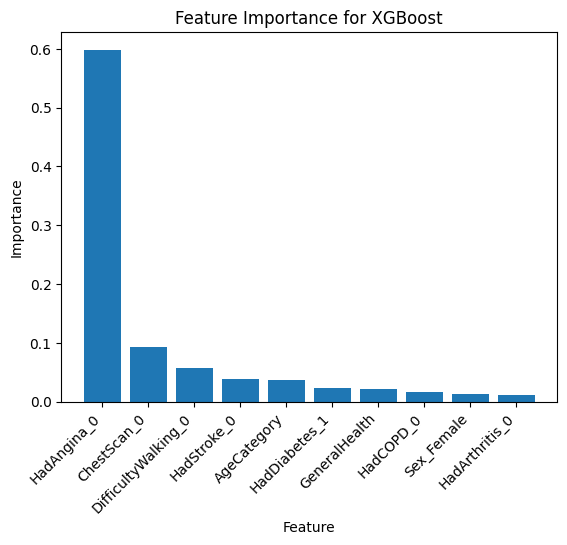

In [ ]:
# plot feature importance
from matplotlib import pyplot
pyplot.bar(importance_table.iloc[:10,0], importance_table.iloc[:10,1])
pyplot.xlabel('Feature')
pyplot.xticks(rotation=45, ha='right')
pyplot.ylabel('Importance')
pyplot.title('Feature Importance for XGBoost')
pyplot.show()

Accuracy: 0.9394666003121678
Recall: 0.5117389574214086
Precision: 0.47020109689213896
F1 Score: 0.49009146341463417


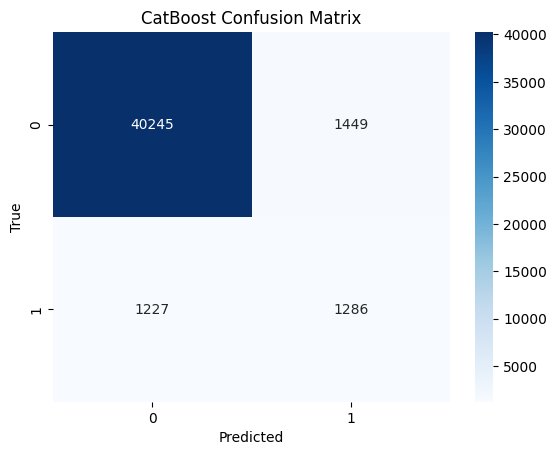

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     41694
           1       0.47      0.51      0.49      2513

    accuracy                           0.94     44207
   macro avg       0.72      0.74      0.73     44207
weighted avg       0.94      0.94      0.94     44207



In [106]:
# Catboost

# install catboost
#!pip install catboost

from catboost import CatBoostClassifier

# fit catboost model
cat = CatBoostClassifier(learning_rate=0.05, depth=4, scale_pos_weight=3.15,silent=True)
cat.fit(X_train, y_train)
acc, rec, pre, f1 = get_scores(cat, X_train, X_val, y_train, y_val, print_result=True, title="CatBoost Confusion Matrix")

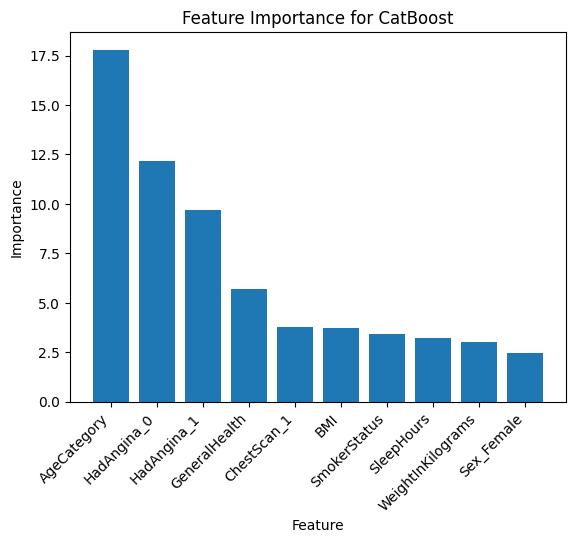

In [ ]:
# CatBoost importance
cat_importance = cat.get_feature_importance(prettified=True)
pyplot.bar(cat_importance.iloc[:10,0], cat_importance.iloc[:10,1])
pyplot.xlabel('Feature')
pyplot.xticks(rotation=45, ha='right')
pyplot.ylabel('Importance')
pyplot.title('Feature Importance for CatBoost')
pyplot.show()

In [ ]:
importance_table

,feature,importance
0,GeneralHealth,17.800872
1,PhysicalHealthDays,12.188832
2,MentalHealthDays,9.674687
3,LastCheckupTime,5.694842
4,SleepHours,3.789703
...,...,...
67,PneumoVaxEver_1,0.134066
68,HighRiskLastYear_0,0.121430
69,HighRiskLastYear_1,0.118888
70,PhysicalActivities_0,0.021560


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9469088605876897
Recall: 0.2785515320334262
Precision: 0.5672609400324149
F1 Score: 0.37363223912463306


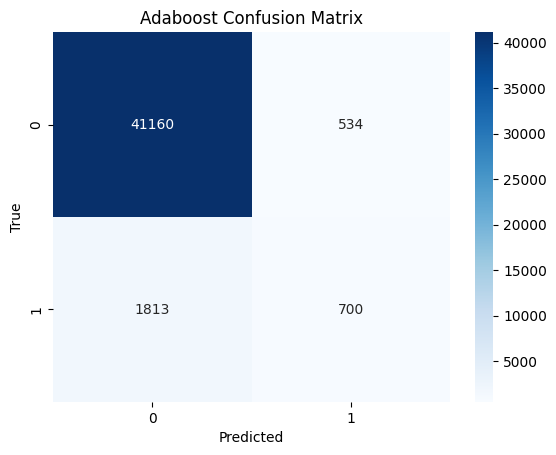

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     41694
           1       0.57      0.28      0.37      2513

    accuracy                           0.95     44207
   macro avg       0.76      0.63      0.67     44207
weighted avg       0.94      0.95      0.94     44207



In [99]:
# adaboost
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.9)
adaboost.fit(X_train, y_train)
acc, rec, pre, f1 = get_scores(adaboost, X_train, X_val, y_train, y_val, print_result=True, title="Adaboost Confusion Matrix")